# Time Series Analysis of `Apple, Inc.` stock values

Time series analysis refers to the analysis of change in the trend of the data over a period of time. Time series analysis has a variety of applications. One such application is the prediction of the future price of an item based on item's past price.  
We will demonstrate time series analysis with the help of an LSTM network. We will be predicting the future stock prices of the Apple Company (AAPL), based on its stock prices of the past 8 years.

For various manipulations we will need Numpy and will plot the results using matplotlib

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
import tensorflow as tf

I am just curious whether my GPU card is still visible, so let me do the following.

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 226072952067722150
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 21985886208
locality {
  bus_id: 1
  links {
  }
}
incarnation: 538715652694513003
physical_device_desc: "device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9"
xla_global_id: 416903419
]


As a data set we will fetch a long string of Apple stock values at Yahoo Finance. Please go to https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch .
We could adjust the start date and the end data of the report. For training data we selected the period between November 7th, 2016 and September 13th, 2024.
Free tier of Yahoo Finance does not allow free download of selected data. This is an inconvenience.  I literaly copied the displayed data into an Excel spreadsheet and store the data im UTF8 CSV file AAPL.csv
To test predictive power of our LSTM model, we will use the Apple stock prices for the period between September 16th, 2024 and November 6th, 2024. The test data are stored in UTF8 CSV file APPL_test.csv


Downloaded data are loaded in a panda. Besides the date column, downloaded data have 6 features: Open,	High,	Low, Close,	Adj Close, and	Volume.
    At the moment, we do not care about all of those features. We will look only at the opening price (column Open) and ignore the others.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
apple_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Deep Learning/APPL.csv')

Data copied from the Yahoo Web page unfortunately had lines with dividents and date and number formats are not in proper order. We will use several Panad transformation to cleanup the data.

In [23]:
apple_train.count()

,0
Date,2007
Open,2007
High,1975
Low,1975
Close,1975
Adj Close,1975
Volume,1975


It appears that we have some 30+ lines which are not complete. We can elliminate them using panda.dropna() method.

In [24]:
apple_train.dropna(inplace=True)

In [25]:
apple_train.count()

,0
Date,1975
Open,1975
High,1975
Low,1975
Close,1975
Adj Close,1975
Volume,1975


In [26]:
apple_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13-Sep-24,223.58,224.04,221.91,222.50,222.50,"36,766,600"
1,12-Sep-24,222.5,223.55,219.82,222.77,222.77,"37,498,200"
2,11-Sep-24,221.46,223.09,217.89,222.66,222.66,"44,587,100"
3,10-Sep-24,218.92,221.48,216.73,220.11,220.11,"51,591,000"
4,9-Sep-24,220.82,221.27,216.71,220.91,220.91,"67,180,000"


The data format is not standard. We have transfrom it into one of standard formats.

In [27]:
%%timeit
apple_train['Date'] = pd.to_datetime(apple_train['Date'], format='mixed')

1.48 ms ± 6.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Column Open should contain floating point numbers and not text.

In [28]:
apple_train['Open']=pd.to_numeric(apple_train['Open'])

In [29]:
apple_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-09-13,223.58,224.04,221.91,222.50,222.50,"36,766,600"
1,2024-09-12,222.50,223.55,219.82,222.77,222.77,"37,498,200"
2,2024-09-11,221.46,223.09,217.89,222.66,222.66,"44,587,100"
3,2024-09-10,218.92,221.48,216.73,220.11,220.11,"51,591,000"
4,2024-09-09,220.82,221.27,216.71,220.91,220.91,"67,180,000"


We should order Panda rows by the Date column in ascending order

In [30]:
apple_train = apple_train.sort_values('Date')

Such cleaned data could now be passed to panda's plot() method.

<Axes: xlabel='Date'>

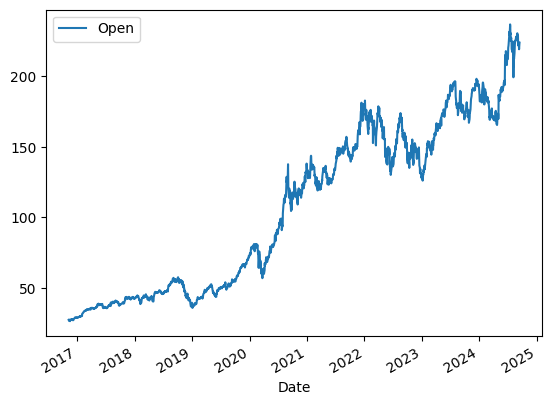

In [31]:
apple_train.plot(x='Date',y='Open')

In [32]:
apple_train.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4,2024-09-09,220.82,221.27,216.71,220.91,220.91,"67,180,000"
3,2024-09-10,218.92,221.48,216.73,220.11,220.11,"51,591,000"
2,2024-09-11,221.46,223.09,217.89,222.66,222.66,"44,587,100"
1,2024-09-12,222.50,223.55,219.82,222.77,222.77,"37,498,200"
0,2024-09-13,223.58,224.04,221.91,222.50,222.50,"36,766,600"


In [33]:
#!pip install openpyxl

If you want to save cleaned data, do the following.

In [34]:
apple_train.to_excel('exported_data.xlsx')

In [35]:
# We do not want to analyze various prices of Apple stock durign the day. We are interested only in the opening prices.
# The following selects only data in column `Open`
apple_train_open = apple_train.iloc[:, 1:2].values

In [36]:
apple_train_open.size

1975

In [37]:
print(type(apple_train_open))

<class 'numpy.ndarray'>


In [38]:
print(apple_train_open)
print("length of the dataset: ", apple_train_open.size)

[[ 27.52]
 [ 27.58]
 [ 27.47]
 ...
 [221.46]
 [222.5 ]
 [223.58]]
length of the dataset:  1975


Before we feed the data to the neural network, we need to normilize the values. We will use SciKit-Learn `MinMaxScaler` from `sklearn.preprocessing` libary. All values of the `Open` price will be scaled into the interval between 0 and 1.

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

apple_train_scaled = scaler.fit_transform(apple_train_open)

In time series problems, we have to predict (forecast) a value at day (time) T, based on the data from N days before, starting at day T-N.  We will try predicting the Open(ing) stock price of Apple based on the opening stock prices for the past N=60 days. One could try different values of N and see how precision of the forecasting algorithm changes with the length of the interval. We will not do that in this exercise.

In the script below we create two lists: `feature_set` and `labels`. There are 1975 records in the training data. We execute a loop that starts from 61st record and stores all the previous 60 records to the `feature_set` list. The 61st record is stored in the `labels` list. We will roll the interval of length N=60 from the beginning of our observations (data) and consider every 60 data points in the interval as `feature_set`. The 61st point just after such interval is the future value we use as the `label`.

In [40]:
features_set = []
labels = []
for i in range(60, 1975):
    features_set.append(apple_train_scaled[i-60:i, 0])
    labels.append(apple_train_scaled[i, 0])


We need to convert both the feature_set and the labels lists to the numpy arrays before we can use them for training. Execute the following code:

In [41]:
features_set, labels = np.array(features_set), np.array(labels)

What are the dimensions of the feature set?

In [42]:
print(features_set.shape[0], features_set.shape[1], 1)

1915 60 1


## Convert Training Data to Right Shape
In order to train LSTM, we need to convert our data into the three-dimensional shape accepted by the LSTM.

The first dimension is the number of records or rows in the dataset which is 1976 in our case.
The second dimension is the number of time steps which is 60.
The last dimension is the number of indicators (labels). Since we are only using one value, i.e. column `Open`, the number of indicators is 1 (one). Execute the following code:

In [43]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))

In [44]:
print(features_set.shape)

(1915, 60, 1)


## Traning the LSTM
We will use tf.Keras API.
The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a Dense layer that predicts the future stock price.
Let's first import the libraries that we will need in order to create our model:

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


## Building the Model

As a first step, we need to instantiate the Sequential class. This is our model class and we will add LSTM, Dropout and Dense layers to this model. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

The second parameter is `return_sequences`, which is set to `True`. We are adding more LSTM layers to the model and every subsequent LSTM layer needs information about all outputs of all cells for every element of the input sequence.

Parameter `return_sequences`=`True`: `Boolean` tells the cell whether to return the last output in the output sequence (`False`), or the full sequence (`True`). When `return_sequences=True` the cell returns the hidden state output for each input time step. When stacking LSTM layers, you must set `return_sequnce` to `True`

We are leaving
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up an RNN or LSTM, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In [46]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1),unroll=False))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


To avoid over-fitting, we will add Dropout layers.

In [47]:
model.add(Dropout(0.2))

In [48]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))


The number of neurons, units = 50, in every LSTM subcell is somewhat arbitrary. You should play with that parameter and find an optimal value

## Creating Dense Layer

To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.


In [49]:
model.add(Dense(units = 1))

In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation
Finally, we need to compile our LSTM model before we can train it on the training data. The following code compiles the model.

In [51]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Model Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the `fit` method on the model and pass it our training features and labels as shown below:


In [52]:
history = model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0477
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0028
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

In [53]:
from tensorflow.keras.models import load_model
model.save('apple.h5')
#model = load_model('apple.h5')
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

From the above, we see that our model history contains information only on the training loss. Had we had validation data passed to the training process we would have had validation loss and perhaps accuracy available as well.

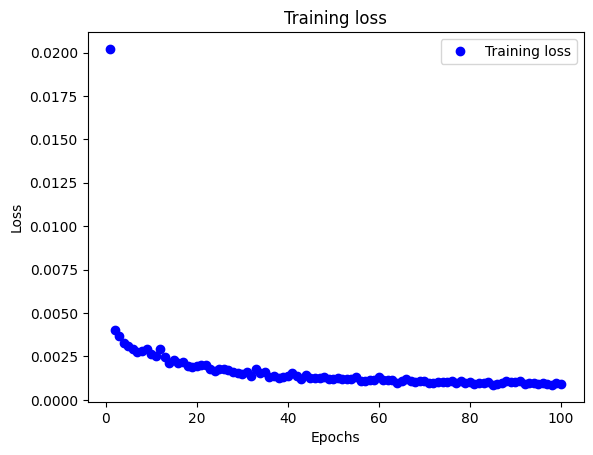

In [54]:
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Testing our LSTM
We have trained our LSTM, now is the time to test the performance of trained model on the test set by predicting the opening stock prices for the month of August 2020.

As we did with the training data, we need to convert our test data in the right format using panda transformations.
Let's first import our test data. Execute the following:


In [56]:
apple_test = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/Deep Learning/APPL_test.csv')

In [57]:
apple_test.dropna(inplace=True)
apple_test.count()

,0
Date,37
Open,37
High,37
Low,37
Close,37
Adj Close,37
Volume,37


In [58]:
apple_test['Date'] = pd.to_datetime(apple_test['Date'], format='mixed')

In [59]:
apple_test['Open']=pd.to_numeric(apple_test['Open'])

In [60]:
apple_test = apple_test.sort_values('Date')

In [61]:
apple_test

,Date,Open,High,Low,Close,Adj Close,Volume
36,2024-09-16,216.54,217.22,213.92,216.32,216.32,"59,357,400"
35,2024-09-17,215.75,216.90,214.50,216.79,216.79,"45,519,300"
34,2024-09-18,217.55,222.71,217.54,220.69,220.69,"59,894,900"
33,2024-09-19,224.99,229.82,224.63,228.87,228.87,"66,781,300"
32,2024-09-20,229.97,233.09,227.62,228.20,228.20,"318,679,900"
31,2024-09-23,227.34,229.45,225.81,226.47,226.47,"54,146,000"
30,2024-09-24,228.65,229.35,225.73,227.37,227.37,"43,556,100"
29,2024-09-25,224.93,227.29,224.02,226.37,226.37,"42,308,700"
28,2024-09-26,227.30,228.50,225.41,227.52,227.52,"36,636,700"
27,2024-09-27,228.46,229.52,227.30,227.79,227.79,"34,026,000"


Data with one column with values for open(ing) prices are contained in `apple_test_open`

In [62]:
apple_test_open = apple_test.iloc[:, 1:2].values

print("Number of data points in test data: ", apple_test_open.size)

Number of data points in test data:  37


## Creating Feature Vectors for the Test Data

For each day of the test set with days in September, October and November, we want our feature set to contain the opening stock prices for the previous 60 days. For example, to predict the price for the 18th of September, we need the features, i.e., the stock prices for the previous 60 days. In other words, for every day in the test set, the feature vector of length 60 will partially scan the data in the training set and partially in the test set. To create a unified set, we need to concatenate our training data and the test data.

Execute the following to do so:

In [63]:
apple_total = pd.concat((apple_train['Open'], apple_test['Open']), axis=0)

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for 37 test days for the months of September, October and November and the 60 opening prices from the last 60 days in the training set. Execute the following code to fetch those 37+60 = 97 values.

In [64]:
test_inputs = apple_total[len(apple_total) - len(apple_test) - 60:].values

In [65]:
test_inputs

array([213.93, 210.39, 207.72, 209.15, 211.5 , 214.69, 215.77, 212.09,
       216.15, 220.  , 221.65, 227.09, 227.93, 229.3 , 231.39, 228.92,
       236.48, 235.  , 229.45, 230.28, 224.82, 227.01, 224.37, 224.  ,
       218.93, 218.7 , 216.96, 219.19, 221.44, 224.37, 219.15, 199.09,
       205.3 , 206.9 , 213.11, 212.1 , 216.07, 219.01, 220.57, 224.6 ,
       223.92, 225.72, 225.77, 226.52, 227.79, 225.66, 226.76, 226.  ,
       227.92, 230.1 , 230.19, 228.55, 221.66, 221.63, 223.95, 220.82,
       218.92, 221.46, 222.5 , 223.58, 216.54, 215.75, 217.55, 224.99,
       229.97, 227.34, 228.65, 224.93, 227.3 , 228.46, 230.04, 229.52,
       225.89, 225.14, 227.9 , 224.5 , 224.3 , 225.23, 227.78, 229.3 ,
       228.7 , 233.61, 231.6 , 233.43, 236.18, 234.45, 233.89, 234.08,
       229.98, 229.74, 233.32, 233.1 , 232.61, 229.34, 220.97, 220.99,
       221.8 ])

It looks like we concatenated two datasets in the proper order.

In [66]:
test_inputs.shape

(97,)

As we did for the training set, we need to scale the test data. Execute the following:

In [67]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)


We scaled our data, now let's prepare the final test input set that will contain previous 60 stock prices for every day in the test set. Execute the following:

In [68]:
test_features = []
for i in range(60, 97):
    test_features.append(test_inputs[i-60:i, 0])


Finally, we need to convert our test data into the three-dimensional format which can be used as input to the LSTM. Execute the following code:

In [69]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))


## Making Predictions
We preprocessed the test data and now we can use them to make predictions. To do so, we simply need to call the `predict()` method on the `model` that we trained. Execute the following


In [70]:
predictions = model.predict(test_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we use the `ìnverse_transform` method of the `scaler` object we created during the training. This is accomplished with the following

In [71]:
predictions = scaler.inverse_transform(predictions)

Finally, let us see how well did our network predicted the future stock prices. Blue values are actual prices of Apple stock in August 2020. The red values are predictions based on the historic prices, from January 2012 to the end of July 2020.

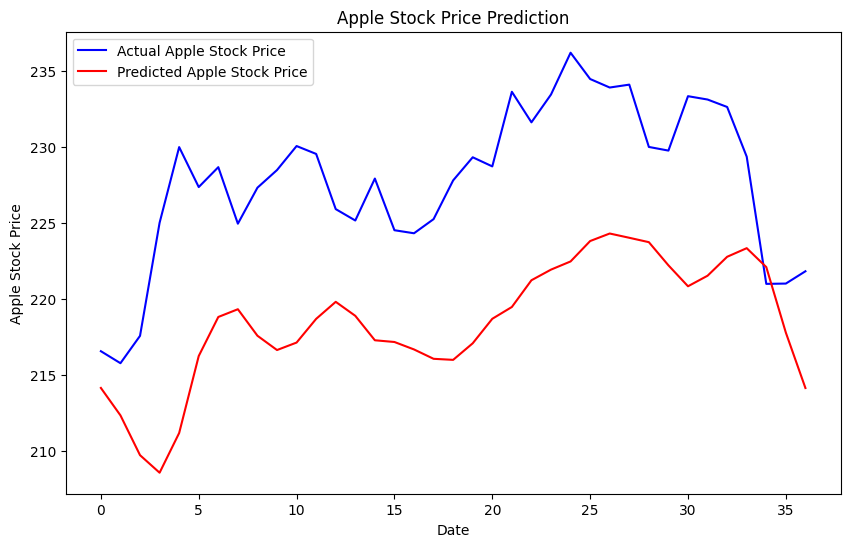

In [72]:
plt.figure(figsize=(10,6))
plt.plot(apple_test_open, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()


At least, the trend is correct.